In [1]:
import numpy as np

class BernoulliBandit :
    def __init__(self, K) :
        self.probs = np.random.uniform(size=K)
        self.K = K
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        
    def step(self, k:int) :
        if np.random.rand() < self.probs[k] :
            return 1
        return 0
    def status(self) :
        print(self.probs, self.K, self.best_prob, self.best_idx)

bb = BernoulliBandit(10)
reward = bb.step(int(2))
print(reward)
bb.status()

1
[0.71676887 0.4765181  0.43007608 0.28146195 0.24640456 0.25798505
 0.00607114 0.46551241 0.87260559 0.87400468] 10 0.8740046809851783 9


In [2]:
class Solver :
    def __init__(self, bandit) :
        self.bandit = bandit
        self.counter = [0 for i in range(bandit.K)]
        self.regrets = [] #[0 for i in range(bandit.K)] 是懊悔记录，不是每个臂的懊悔，别跟reward混淆
        self.regret = 0
    def run_one_step(self) :
        # choose one bandit and return
        return np.random.randint(0, self.bandit.K)

    def update_regret(self, k) :
        # 每次的懊悔累积,记录下来。相当于是懊悔的定积分。
        self.regret += self.bandit.best_prob - self.bandit.probs[k] 
        self.regrets.append(self.regret)
    
    def run(self, max_step) :
        for i in range(max_step) :
            k = self.run_one_step()
            self.counter[k] += 1
            self.update_regret(k)
    def until_cond(self) :
        return False
    def run_until(self, max_step) :
        for i in range(max_step) :
            if self.until_cond() :
                return i
            k = self.run_one_step()
            self.counter[k] += 1
            self.update_regret(k)
        return max_step
    
    def status(self) :
        print("counter:", self.counter)
        print("regrets:", self.regrets)
s = Solver(bb)
s.run(10)
s.run_until(10)
s.status()

counter: [2, 1, 3, 3, 3, 1, 3, 2, 1, 1]
regrets: [0.4439286044260452, 1.311862142165244, 1.9394622595894806, 2.096698073227939, 2.4941846588747962, 3.362118196613995, 3.519354010252454, 3.9278462782988015, 4.543865907373435, 5.171466024797672, 5.764008755162552, 6.2079373595885965, 6.2079373595885965, 6.651865964014641, 7.244408694379521, 8.11234223211872, 8.113741322224158, 8.522233590270506, 9.114776320635386, 9.742376438059623]


In [3]:
class EpsilonGreedy(Solver) :
    def __init__(self, bandit, epsilon=0.01) :
        super().__init__(bandit)
        self.epsilon = epsilon
        self.estimates = [1.0 for i in range(0, self.bandit.K)]

    def run_one_step(self) :
        if np.random.rand() < self.epsilon :
            k = np.random.randint(0, self.bandit.K)
        else :
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.counter[k] += 1
        self.estimates[k] += ((r - self.estimates[k]) / (self.counter[k] + 1))
        return k

这里estimates初始化值设置成1有讲究。  
这叫乐观初始值，理论上应该设置为比最大reward更大的值。这里reward返回0和1，所以设置成1.  
这会影响贪婪行动（np.random.rand() > self.epsilon）时的选择。  
想象最开始所有动作估计都初始化成最大值。这时候选了一个动作，计算出来的估计必然小于0，更小于其他动作的初始值。  
这会导致下一次再进行贪婪行动的时候，选择那些还未尝试过的动作。

In [4]:
import matplotlib.pyplot as plt

def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

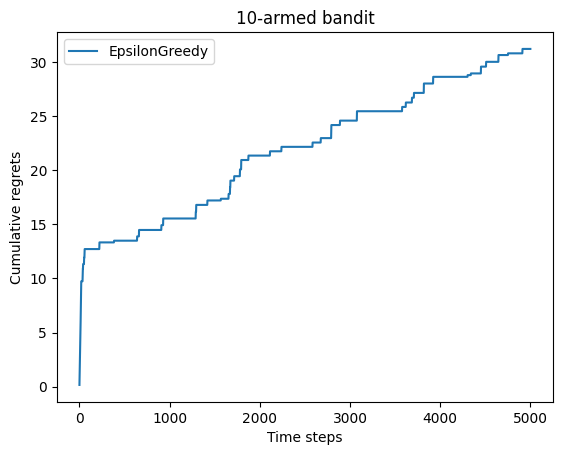

In [5]:
np.random.seed(1)
eg = EpsilonGreedy(bb, 0.01)
eg.run(5000)
plot_results([eg], ['EpsilonGreedy'])

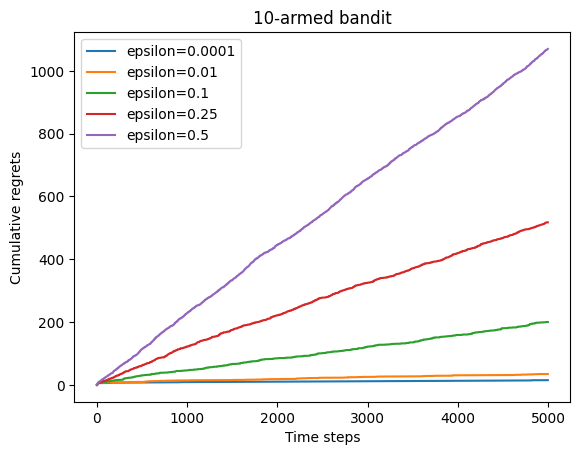

In [6]:
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bb, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

懊悔是个评估指标，相当于监督学习里的label。实际任务中不可能提前知道哪个是最优的策略。  
epsilon越大，随机性越强，越难选到最优策略，懊悔也就越大。  
epsilon设为0，贪婪策略，几轮就能找到最优策略，懊悔不再增长了。

In [7]:
class DecaylingEpsilonGreedy(Solver) :
    def __init__(self, bandit) :
        super().__init__(bandit)
        self.estimates = [1.0 for i in range(0, self.bandit.K)]
        self.total_count = 1

    def run_one_step(self) :
        self.total_count += 1
        if np.random.rand() < 1 / self.total_count :
            k = np.random.randint(0, self.bandit.K)
        else :
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += ((r - self.estimates[k]) / (self.counter[k] + 1))
        return k

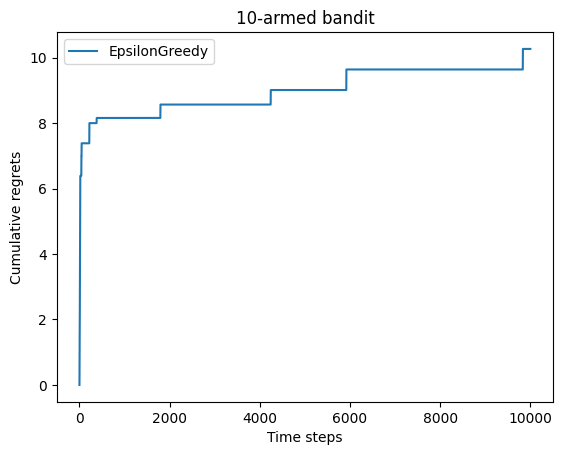

In [8]:
np.random.seed(1)
eg = DecaylingEpsilonGreedy(bb)
eg.run(10000)
plot_results([eg], ['EpsilonGreedy'])

到这我有一个疑问：  
既然每台老虎机的概率分布是固定的，不会随着策略变化而变化，那为什么不这么解：  
每台老虎机试x次，计算奖励均值以估计期望，后边选期望最大的那台老虎机即可。  
LLM说：
1. 探索效率低。这个有可能，x设置到多少合适，一共需要试验x * K次，才得出结果。而且按照大数定律，x越大越准。
2. 无法应对动态变化。这有点扯淡了，推翻了基本假设。当然探索性算法的动态探索能力肯定更强。
3. 理论性能差距，也就是累计懊悔，它认为我的方法会越来越大。我不太信，我觉得试x次之后我就找到了最佳答案，懊悔降为0.  

我也写个代码比较下。
1. 调整x，看看多少次懊悔才能降到0.

In [9]:
class JustTryIt(Solver) :
    def __init__(self, bandit, x=10) :
        super().__init__(bandit)
        self.estimates = [1.0 for i in range(0, self.bandit.K)]
        self.x = x
        self.max_count = 0

    def until_cond(self) :
        if np.argmax(self.estimates) == self.bandit.best_idx :
            self.max_count += 1
        return self.max_count > 10
        
    def run_one_step(self) :
        try_all = True
        for i in range(self.bandit.K) :
            if self.counter[i] < self.x :
                k = i
                try_all = False
                break
        if try_all :
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += ((r - self.estimates[k]) / (self.counter[k] + 1))

        return k

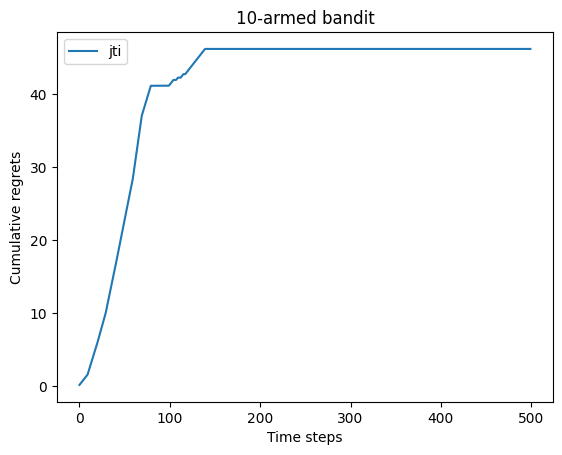

In [10]:
np.random.seed(1)

jti=JustTryIt(bb, x=10)
jti.run(500)

plot_results([jti], ['jti'])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] [40, 5000, 5000, 51, 5000, 5000, 121, 83, 111, 91, 102, 107, 115, 123, 142, 142, 175, 162, 169]


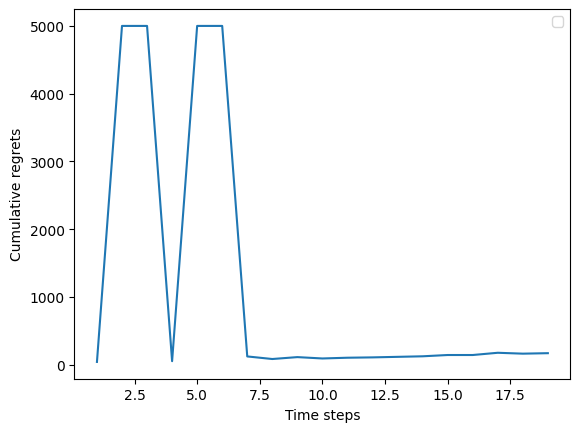

In [11]:

xs = [i for i in range(1,20)]
ys = []
epsilon_greedy_solver_list = [
    JustTryIt(bb, x=x) for x in xs
]
epsilon_greedy_solver_names = ["x={}".format(x) for x in xs]
for solver in epsilon_greedy_solver_list:
    np.random.seed(1)
    ys.append(solver.run_until(5000))
print(xs, ys)

plt.plot(xs, ys, label='')
plt.xlabel('Time steps')
plt.ylabel('Cumulative regrets')
plt.title('')
plt.legend()
plt.show()

好吧，这么写本身就不太对。x其实就是固定探索次数，x增加固定探索次数会增加，会提高固定探索后找到正确答案的概率。  
不一定x小就找不到正确答案，也可能随机就找到了正确答案。所以，y定义为多少次尝试后懊悔不增加没意义。  

霍夫丁不等式  
是说，有一个随机变量X，为了估计它的值，进行n次采样，得到一系列随机变量$X_1$,$X_2$...$X_n$.用这n个随机变量的均值来估计随机变量X。均值：$\bar{x}_n = \sum_{j=1}^{n} X_j$。  
霍夫丁不等式给出了估计的误差上界：  
$\mathbb{P}(\mathbb{E}[X] \ge \bar{x}_n + u) \le e^{-2nu^2}$  
感觉这个等式这么写理解起来有点费劲。不如这么用估计值的视角写：  
$\mathbb{P}(\bar{x}_n \le \mathbb{E}[X] - u) \le e^{-2nu^2}$  
$\mathbb{E}[X]$是期望，是固定值。$\bar{x}_n$是采样出来的随机变量得出的随机变量。也就是说，采样值估计出来的随机变量小于期望-u的概率低于$e^{-2nu^2}$。

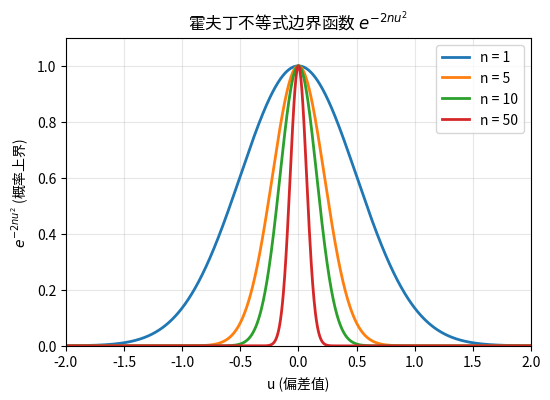

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

# 定义u的取值范围：从-100到+100
u = np.linspace(-2, 2, 1000)

# 定义不同的n值（样本量）
n_values = [1, 5, 10, 50]

# 创建图形
plt.figure(figsize=(6, 4))

# 为每个n值绘制对应的函数曲线
for n in n_values:
    # 计算霍夫丁边界函数值：e^(-2nu²)
    y = np.exp(-2 * n * u**2)
    plt.plot(u, y, label=f'n = {n}', linewidth=2)

# 设置图形属性
plt.xlabel('u (偏差值)')
plt.ylabel(r'$e^{-2nu^2}$ (概率上界)')
plt.title(r'霍夫丁不等式边界函数 $e^{-2nu^2}$')
plt.legend()
plt.grid(True, alpha=0.3)

# 设置坐标轴范围
plt.xlim(-2, 2)
plt.ylim(0, 1.1)

# 显示图形
plt.show()

可以看到，随着u增加，概率上界减小。也就是说估计值落在期望附近的概率很高，越远离期望，概率越低。  
随着n也就是采样样本数量增加，估计值偏离期望的概率也越低。也就是采样数量越大，得到的估计值越接近期望。  

霍夫丁不等式用于多臂老虎机  
这块有一点绕。需要梳理下。  
现在问题是这样的，在t时刻，对于某个老虎机a,通过$\epsilon-greedy$策略，拉杆$N_t(a)$次，通过前几次拉杆的奖励结果，计算得到了平均奖励$\hat{Q}_t(a)$，来估计这个老虎机a的奖励期望。这个通过n次拉杆估计出来的奖励值，不知道偏离期望多远，是否置信。  
以上信息对比霍夫丁不等式：  
$\mathbb{P}(\mathbb{E}[X] \ge \bar{x}_n + u) \le e^{-2nu^2}$  
$\hat{Q}_t(a)$就是通过$N_t(a)$次采样得到的估计值，对应公式中的$\bar{x}_n$，$N_t(a)$对应公式中的n，由于每个好估计拉杆次数不同，所以用一个函数表示。  
此时，如果选取一个u，或者说$\hat{U}_t(a)$，就可以根据不等式计算出估计值偏离期望$\hat{U}_t(a)$的概率。  
但在多臂老虎机问题中，知道置信度没什么用，我们想要知道的其实是，在置信度固定的情况下，奖励的上界。也就是在$e^{-2nu^2}$固定的情况下，想知道$\bar{x}_n + u$是多少。转换成具体问题就是，$e^{-2N_t(a)\hat{U}_t(a)^2}$固定的情况下，$\hat{Q}_t(a)+\hat{U}_t(a)$的上界。这样这个上界其实衡量了在当前样本数量及置信度下，奖励最高能达到多少。从而可以选择那个最可信、奖励最高的动作。  
为了通过设置置信度获取偏离$\hat{U}_t(a)$,设置信度为p，有$p=e^{-2N_t(a)\hat{U}_t(a)^2}$，解：  
$
\begin{align}
p &= e^{-2N_t(a)\hat{U}_t(a)^2}\\
\log p &= -2N_t(a)\hat{U}_t(a)^2 \\
\frac{\log p}{-2N_t(a)} &= \hat{U}_t(a)^2 \\
\sqrt{\frac{\log p}{-2N_t(a)}} &= \hat{U}_t(a)\\
\hat{U}_t(a) &= \sqrt{\frac{\log p}{-2N_t(a)}}
\end{align}
$  
通过上式，设置好置信度p之后，根据当前老虎机拉动次数，就可以得出置信区间。将奖励均值$\hat{Q}_t(a)$加上置信区间，就可以得到当前拉动次数下可信的最高奖励。  

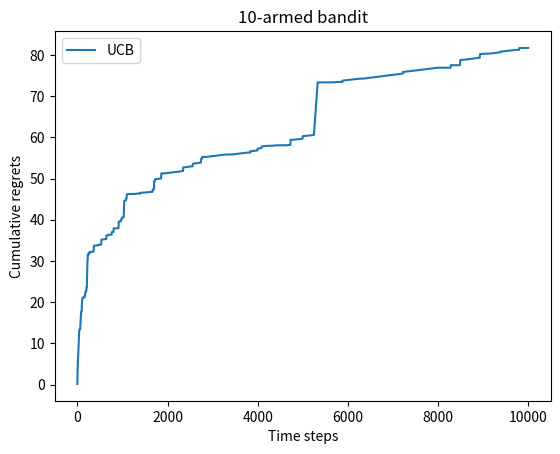

In [13]:
import math

class UCB(Solver):
    def __init__(self, bandit, c=1) :
        super().__init__(bandit)
        self.estimates = [1.0 for i in range(0, self.bandit.K)]
        self.total_count = 0
        self.c = c

    def run_one_step(self) :
        self.total_count += 1
        ucb = []

        for i in range(0, self.bandit.K) :
            u = self.estimates[i] + self.c * math.sqrt(math.log(self.total_count) / (2*self.counter[i] + 1))
            ucb.append(u)
        k = np.argmax(ucb)

        r = self.bandit.step(k)
        self.estimates[k] += ((r - self.estimates[k]) / (self.counter[k] + 1))
        return k

np.random.seed(1)
eg = UCB(bb)
eg.run(10000)
plot_results([eg], ['UCB'])

汤普森采样：  
昨天没想明白，早上起来想了一下似乎明白了。  
汤普森采样和Beta分布不是绑定的。只是在现在这个返回奖励是1和0的问题中，可以用Beta分布。对于其他返回奖励类型，还可以用其他分布，主要取决于对数据分布的假定。  
汤普森采样的核心思想是，用平均值来估计期望计算量大。可以根据过去的奖励数据，假定一下过去数据的概率分布，通过概率分布进行采样或者说预估下一次的奖励。  
这个假定的过去数据的概率分布，在这个问题中可以用Beta分布。Beta分布的入参是两个参数，分别是成功和失败的次数，就可以得出一个概率密度曲线，横轴是成功数，纵轴是对应的概率密度。然后根据概率密度曲线做随机采样，获取一个估计的下一次奖励。  
如果是其他比如奖励是连续返回的问题，假定它是正态分布，那可能需要根据过去的值来计算一个正态分布的参数，得到一个正态分布曲线，再根据正态分布曲线进行采样，得到一个估计值。  
总之，都是想根据过去数据的特征来获取一个假定的概率分布曲线，再根据曲线随机采样得到一个估计值。  
这个曲线，在这个简单问题中，是直接用现有的分布模型得出的。复杂问题中，可以用历史数据训练，做拟合，得到一条更准确的分布曲线来做估计，这就是function approximation了。